In [2]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.16.1


In [8]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [9]:
from  IPython import display
from matplotlib import pyplot as plt

import pathlib
import shutil
import tempfile

# Load Hotdog Image

In [10]:
BATCH_SIZE = 32
SIDE_LEN = 128

In [20]:
data_dir = "/Users/brenthoang/Documents/Test_Project/hot-dog/model/original/train"
test_dir = "/Users/brenthoang/Documents/Test_Project/hot-dog/model/original/test"

In [21]:
os.listdir(data_dir)

['.DS_Store', 'not_hotdog', 'hotdog']

In [20]:
# import image
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(SIDE_LEN, SIDE_LEN),  # Resize all images to this size
  batch_size=BATCH_SIZE,
  label_mode='binary',  # Use 'binary' for two-class classification
  validation_split=0.2,  # Split 20% of data for validation
  subset='training',
  seed=123)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(SIDE_LEN, SIDE_LEN),  # Resize all images to this size
  batch_size=BATCH_SIZE,
  label_mode='binary',  # Use 'binary' for two-class classification
  validation_split=0.2,  # Split 20% of data for validation
  subset='validation',
  seed=123)


test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(SIDE_LEN, SIDE_LEN),  # Resize all images to this size
  batch_size=BATCH_SIZE,
  label_mode='binary'
)

NotFoundError: Could not find directory model/original/train/

In [34]:
# mapping hotdog to 1 and not hotdog to 0

train_ds = train_ds.map(
    lambda image, label: (image, tf.cast(label == 0, tf.int32))
)

val_ds = val_ds.map(
    lambda image, label: (image, tf.cast(label == 0, tf.int32))
)

test_ds = test_ds.map(
    lambda image, label: (image, tf.cast(label == 0, tf.int32))
)

In [23]:
def plot_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = 'Hotdog' if labels[i] == 1 else 'Not Hotdog'
            plt.title(label)
            plt.axis("off")
    plt.show()

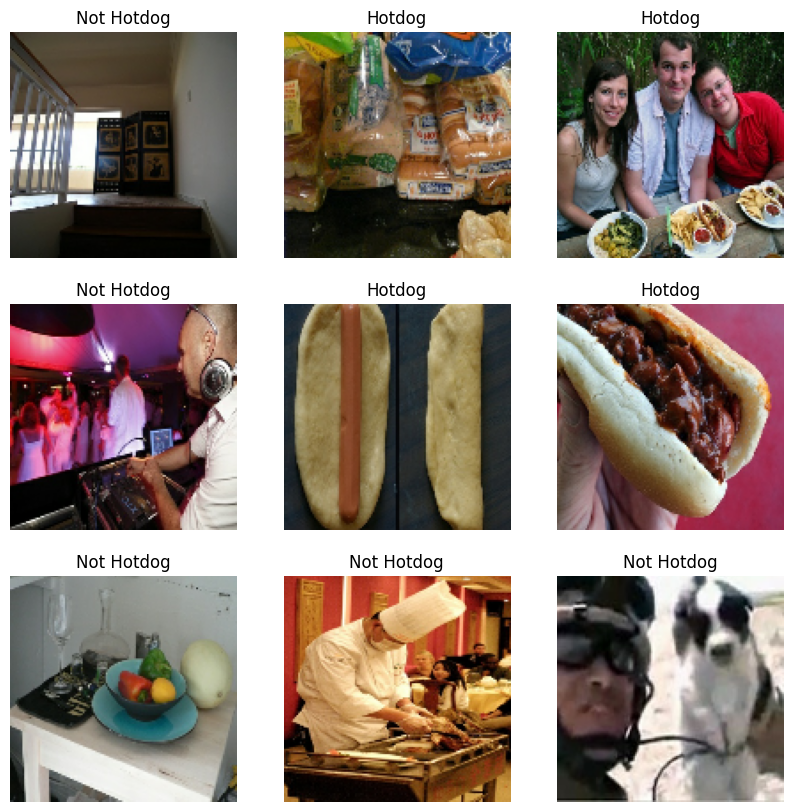

In [24]:
plot_images(train_ds)

# Create Checkpoint

In [25]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

import math
n_batches = math.ceil(len(train_ds))

In [26]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*n_batches)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5,restore_best_weights=True
)

# Optimize Runtime and Create Model

In [27]:
# cache and prefetch for runtime
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
def create_model(): # over fitting add dropout and weight regulizers later
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(SIDE_LEN, SIDE_LEN, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),'accuracy'])

    return model

def fit_model(model):
  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=50,
      callbacks=[cp_callback, early_stopping_callback],
      verbose=1
  )
  return history

def plot_loss(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(10, 6))
  plt.plot(train_loss, label='Training Binary Cross-Entropy')
  plt.plot(val_loss, label='Validation Binary Cross-Entropy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Binary Cross-Entropy over Epochs')
  plt.legend()
  plt.grid(True)
  plt.show()


In [29]:
model = create_model()

# Fit Model

In [30]:
history = fit_model(model)

Epoch 1/50
75/75 [==============================] - 101s 1s/step - loss: 0.6701 - binary_crossentropy: 0.6701 - accuracy: 0.6050 - val_loss: 0.6043 - val_binary_crossentropy: 0.6043 - val_accuracy: 0.6767
Epoch 2/50
75/75 [==============================] - 95s 1s/step - loss: 0.6121 - binary_crossentropy: 0.6121 - accuracy: 0.6654 - val_loss: 0.5989 - val_binary_crossentropy: 0.5989 - val_accuracy: 0.6950
Epoch 3/50
75/75 [==============================] - 94s 1s/step - loss: 0.5749 - binary_crossentropy: 0.5749 - accuracy: 0.7067 - val_loss: 0.5605 - val_binary_crossentropy: 0.5605 - val_accuracy: 0.7083
Epoch 4/50
75/75 [==============================] - 91s 1s/step - loss: 0.5304 - binary_crossentropy: 0.5304 - accuracy: 0.7333 - val_loss: 0.5626 - val_binary_crossentropy: 0.5626 - val_accuracy: 0.7067
Epoch 5/50
74/75 [============================>.] - ETA: 1s - loss: 0.4951 - binary_crossentropy: 0.4951 - accuracy: 0.7530
Epoch 5: saving model to training_2/cp-0005.ckpt
75/75 [===

# Test Model on Testing Set

In [39]:
test_loss, test_acc, *is_anything_else_being_returned = model.evaluate(test_ds)

21/21 [==============================] - 10s 418ms/step - loss: 0.6026 - binary_crossentropy: 0.6026 - accuracy: 0.6801


In [40]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Test Loss: 0.6026282906532288
Test Accuracy: 0.6026282906532288
